# Scale Invariant Feature Transforms
---


1. Scale-invariant feature transform (SIFT) is an algorithm in computer vision to detect and describe local features in images. 

2. The algorithm was patented in the US by the University of British Columbia[1] and published by David Lowe in 1999.

3. Applications include object recognition, robotic mapping and navigation, image stitching, 3D modeling, gesture recognition, video tracking, individual identification of wildlife and match moving.

Harris corner detector has a problem it is not scale invariant although they are rotation-invariant, which means, even if the image is rotated, we can find the same corners. 

![Corners](./harris_corner.jpg)

So, in 2004, D.Lowe, University of British Columbia, came up with a new algorithm, Scale Invariant Feature Transform (SIFT) in his paper, Distinctive Image Features from Scale-Invariant Keypoints, which extract keypoints and compute its descriptors. 

There are mainly four steps involved in SIFT algorithm. We will see them one-by-one.



##  1- Scale-space Extrema Detection
---

1. To detect corners at multiple scales we need multiple scale windows. 
2. For this, scale-space filtering is used. In it, Laplacian of Gaussian is found for the image with various $σ$ values. 
3. LoG acts as a blob detector which detects blobs in various sizes due to change in $σ$. In short, $σ$ acts as a scaling parameter. 

4. For eg, in the above image, gaussian kernel with low σ gives high value for small corner while guassian kernel with high σ fits well for larger corner. 

5. So, we can find the local maxima across the scale and space which gives us a list of (x,y,σ) values which means there is a potential keypoint at (x,y) at σ scale.

6. But this LoG is a little costly, so SIFT algorithm uses Difference of Gaussians which is an approximation of LoG. 

7. Difference of Gaussian is obtained as the difference of Gaussian blurring of an image with two different σ, let it be σ and kσ. 

8. This process is done for different octaves of the image in Gaussian Pyramid. It is represented in below image:

![Corners](./sift_dog.jpg)

Once this DoG are found, images are searched for local extrema over scale and space. For eg, one pixel in an image is compared with its 8 neighbours as well as 9 pixels in next scale and 9 pixels in previous scales. If it is a local extrema, it is a potential keypoint. It basically means that keypoint is best represented in that scale. It is shown in below image:


![Corners](./sift_local_extrema.jpg)

Regarding different parameters, the paper gives some empirical data which can be summarized as, number of octaves = 4, number of scale levels = 5, initial σ=1.6, k=2–√ etc as optimal values.

## 2. Keypoint Localization

Once potential keypoints locations are found, they have to be refined to get more accurate results. 

1. They used Taylor series expansion of scale space to get more accurate location of extrema, and if the intensity at this extrema is less than a threshold value (0.03 as per the paper), it is rejected. This threshold is called contrastThreshold in OpenCV

2. DoG has higher response for edges, so edges also need to be removed. For this, a concept similar to Harris corner detector is used. They used a 2x2 Hessian matrix (H) to compute the pricipal curvature. We know from Harris corner detector that for edges, one eigen value is larger than the other. So here they used a simple function,

3. If this ratio is greater than a threshold, called edgeThreshold in OpenCV, that keypoint is discarded. It is given as 10 in paper.

4. So it eliminates any low-contrast keypoints and edge keypoints and what remains is strong interest points.

## 3. Orientation Assignment

1. Now an orientation is assigned to each keypoint to achieve invariance to image rotation. 

2. A neigbourhood is taken around the keypoint location depending on the scale, and the gradient magnitude and direction is calculated in that region. 

3. An orientation histogram with 36 bins covering 360 degrees is created. (It is weighted by gradient magnitude and gaussian-weighted circular window with σ equal to 1.5 times the scale of keypoint. The highest peak in the histogram is taken and any peak above 80% of it is also considered to calculate the orientation. It creates keypoints with same location and scale, but different directions. It contribute to stability of matching.
![Corners](./sift_desc.jpg)

## 4. Keypoint Descriptor

1. A 16x16 neighbourhood around the keypoint is taken. 
2. It is devided into 16 sub-blocks of 4x4 size. 
3. For each sub-block, 8 bin orientation histogram is created. So a total of 128 bin values are available. 
4. It is represented as a vector to form keypoint descriptor. In addition to this, several measures are taken to achieve robustness against illumination changes, rotation etc.

![Corners](./sift_desc.jpg)

## 5. Keypoint Matching

1. Keypoints between two images are matched by identifying their nearest neighbours. 
2. But in some cases, the second closest-match may be very near to the first. 
3. It may happen due to noise or some other reasons. In that case, ratio of closest-distance to second-closest distance is taken. 
4. If it is greater than 0.8, they are rejected. It eliminaters around 90% of false matches while discards only 5% correct matches, as per the paper.

So this is a summary of SIFT algorithm. For more details and understanding, reading the original paper is highly recommended. Remember one thing, this algorithm is patented. 

# Practical SIFT

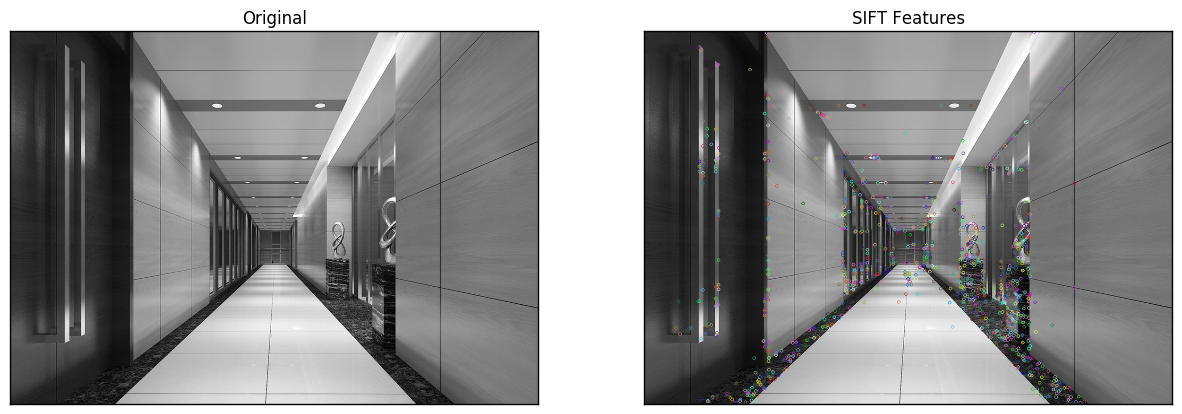

In [1]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline


img = cv2.imread('corridor01.jpg')

gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
imsift = np.copy(img)

sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)

img_sift=cv2.drawKeypoints(gray,kp,imsift)

plt.figure(figsize = (15,10))
plt.subplot(121),plt.imshow(gray, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_sift, cmap='gray'),plt.title('SIFT Features')
plt.xticks([]), plt.yticks([])

plt.show()

sift.detect() function finds the keypoint in the images. You can pass a mask if you want to search only a part of image. Each keypoint is a special structure which has many attributes like its (x,y) coordinates, size of the meaningful neighbourhood, angle which specifies its orientation, response that specifies strength of keypoints etc.

OpenCV also provides cv2.drawKeyPoints() function which draws the small circles on the locations of keypoints. If you pass a flag, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS to it, it will draw a circle with size of keypoint and it will even show its orientation. See below example.

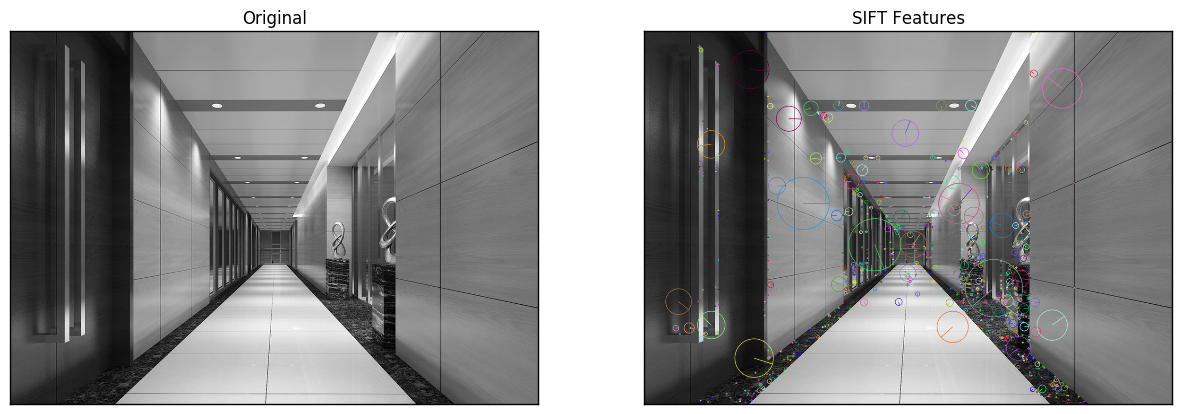

In [2]:
img_enhsift=cv2.drawKeypoints(gray,kp,imsift, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize = (15,10))
plt.subplot(121),plt.imshow(gray, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_enhsift, cmap='gray'),plt.title('SIFT Features')
plt.xticks([]), plt.yticks([])

plt.show()

Now to calculate the descriptor, OpenCV provides two methods.

Since you already found keypoints, you can call sift.compute() which computes the descriptors from the keypoints we have found. Eg: kp,des = sift.compute(gray,kp)
If you didn't find keypoints, directly find keypoints and descriptors in a single step with the function, sift.detectAndCompute().
We will see the second method:

In [3]:
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)
print(kp[0].pt)
print(kp[45].pt)



(259.37066650390625, 5.682672500610352)
(910.6739501953125, 323.62054443359375)


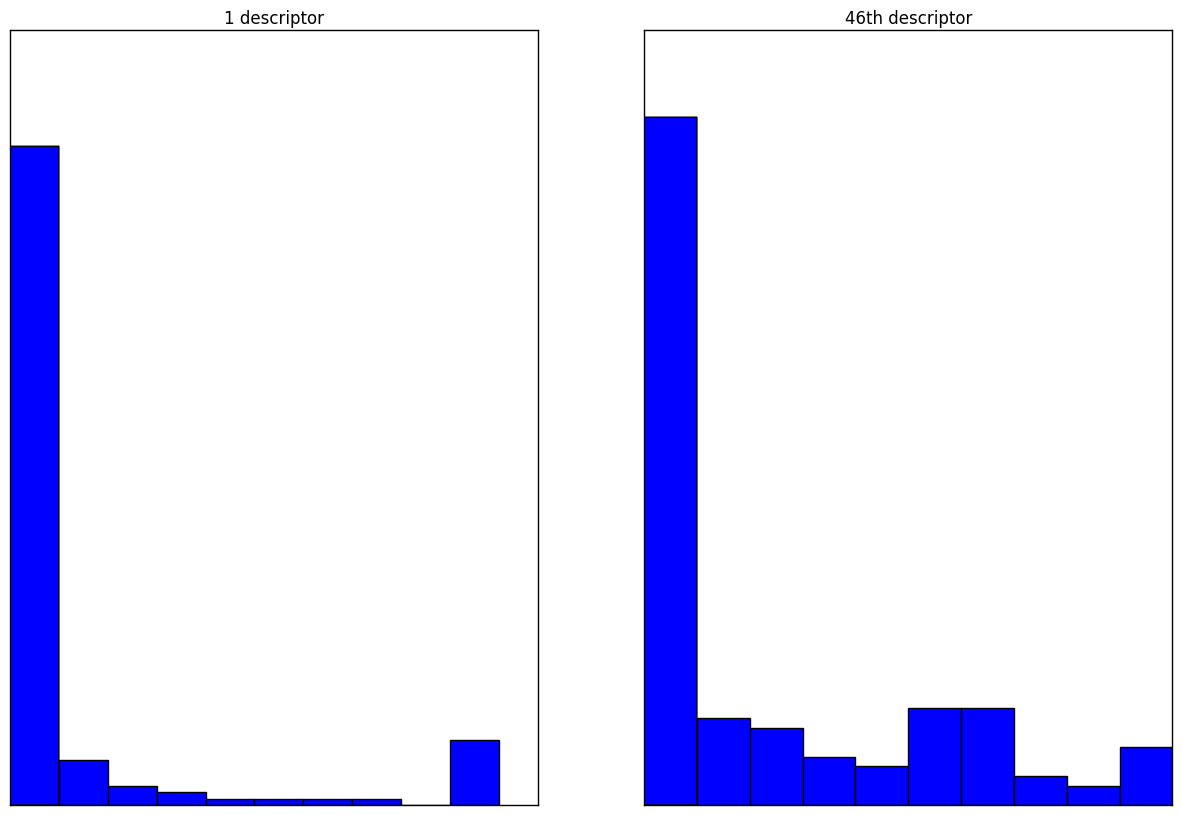

In [4]:
plt.figure(figsize = (15,10))
plt.subplot(121),plt.hist(des[0]),plt.title('1 descriptor')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.hist(des[45]),plt.title('46th descriptor')
plt.xticks([]), plt.yticks([])

plt.show()

## An Application of SIFT in object detection



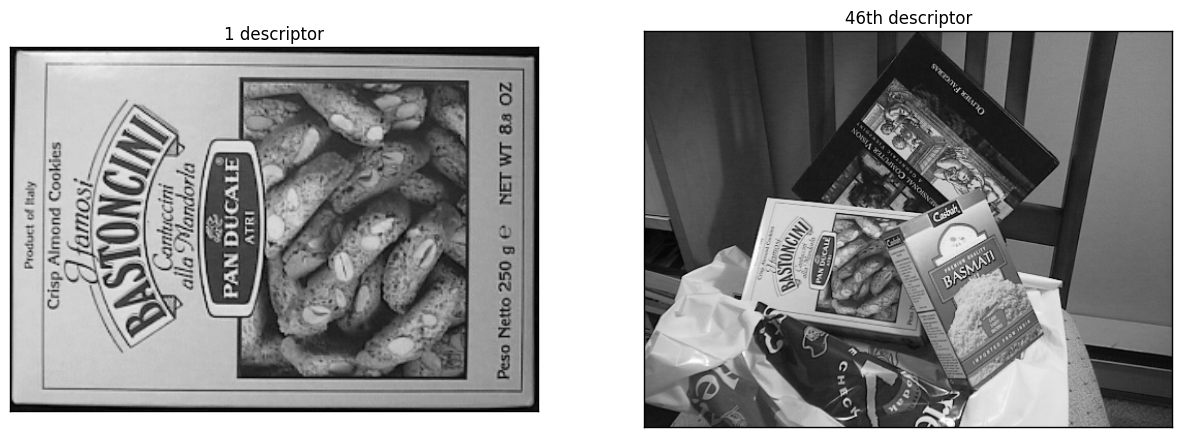

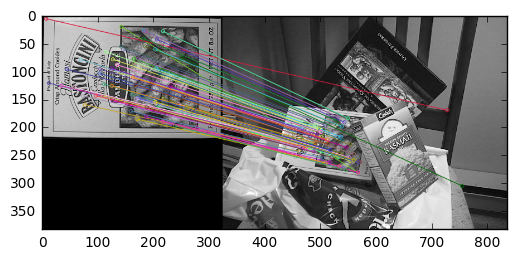

(<matplotlib.image.AxesImage at 0x7f12b5adaa20>, None)

In [26]:

MIN_MATCH_COUNT = 10

img1 = cv2.imread('box.png',0)          # queryImage
img2 = cv2.imread('box_in_scene.png',0) # trainImage

plt.figure(figsize = (15,10))
plt.subplot(121),plt.imshow(img1, cmap='gray'),plt.title('1 descriptor')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img2, cmap='gray'),plt.title('46th descriptor')
plt.xticks([]), plt.yticks([])

plt.show()

# Initiate SIFT detector

sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

outimg = np.copy(img1)
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,outimg,flags=2)

plt.imshow(img3),plt.show()

# Speed Up Robust Features
In last chapter, we saw SIFT for keypoint detection and description. But it was comparatively slow and people needed more speeded-up version. In 2006, three people, Bay, H., Tuytelaars, T. and Van Gool, L, published another paper, "SURF: Speeded Up Robust Features" which introduced a new algorithm called SURF. As name suggests, it is a speeded-up version of SIFT.

In SIFT, Lowe approximated Laplacian of Gaussian with Difference of Gaussian for finding scale-space. SURF goes a little further and approximates LoG with Box Filter. Below image shows a demonstration of such an approximation. One big advantage of this approximation is that, convolution with box filter can be easily calculated with the help of integral images. And it can be done in parallel for different scales. Also the SURF rely on determinant of Hessian matrix for both scale and location.

![Corners](./surf_boxfilter.jpg)


For orientation assignment, SURF uses wavelet responses in horizontal and vertical direction for a neighbourhood of size 6s. Adequate guassian weights are also applied to it. Then they are plotted in a space as given in below image. The dominant orientation is estimated by calculating the sum of all responses within a sliding orientation window of angle 60 degrees. Interesting thing is that, wavelet response can be found out using integral images very easily at any scale. For many applications, rotation invariance is not required, so no need of finding this orientation, which speeds up the process. SURF provides such a functionality called Upright-SURF or U-SURF. It improves speed and is robust upto ±15∘. OpenCV supports both, depending upon the flag, upright. If it is 0, orientation is calculated. If it is 1, orientation is not calculated and it is more faster.


![Corners](./surf_orientation.jpg)




For feature description, SURF uses Wavelet responses in horizontal and vertical direction (again, use of integral images makes things easier). A neighbourhood of size 20sX20s is taken around the keypoint where s is the size. It is divided into 4x4 subregions. For each subregion, horizontal and vertical wavelet responses are taken and a vector is formed like this,$v=( \sum{d_x}, \sum{d_y}, \sum{|d_x|}, \sum{|d_y|})$ . This when represented as a vector gives SURF feature descriptor with total 64 dimensions. Lower the dimension, higher the speed of computation and matching, but provide better distinctiveness of features.

For more distinctiveness, SURF feature descriptor has an extended 128 dimension version. The sums of $d_x$ and $|d_x|$ are computed separately for $dy<0$ and $dy≥0$. Similarly, the sums of $d_y$ and $|d_y|$ are split up according to the sign of dx , thereby doubling the number of features. It doesn't add much computation complexity. OpenCV supports both by setting the value of flag extended with 0 and 1 for 64-dim and 128-dim respectively (default is 128-dim)

Another important improvement is the use of sign of Laplacian (trace of Hessian Matrix) for underlying interest point. It adds no computation cost since it is already computed during detection. The sign of the Laplacian distinguishes bright blobs on dark backgrounds from the reverse situation. In the matching stage, we only compare features if they have the same type of contrast (as shown in image below). This minimal information allows for faster matching, without reducing the descriptor's performance.

![Corners](./surf_matching.jpg)

OpenCV provides SURF functionalities just like SIFT. You initiate a SURF object with some optional conditions like 64/128-dim descriptors, Upright/Normal SURF etc. All the details are well explained in docs. Then as we did in SIFT, we can use SURF.detect(), SURF.compute() etc for finding keypoints and descriptors.

First we will see a simple demo on how to find SURF keypoints and descriptors and draw it. All examples are shown in Python terminal since it is just same as SIFT only.

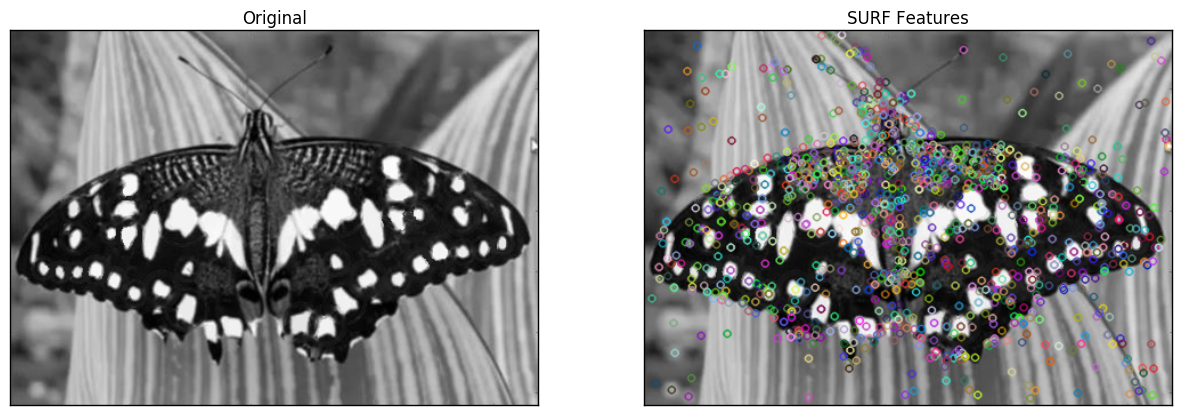

In [47]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline


img = cv2.imread('fly.png')

gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
imsurf = np.copy(img)

surf = cv2.xfeatures2d.SURF_create(5000000)
surf.setHessianThreshold(50000)
kp, des = sift.detectAndCompute(gray,None)

img_surf=cv2.drawKeypoints(gray,kp,imsurf)

plt.figure(figsize = (15,10))
plt.subplot(121),plt.imshow(gray, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_surf, cmap='gray'),plt.title('SURF Features')
plt.xticks([]), plt.yticks([])

plt.show()

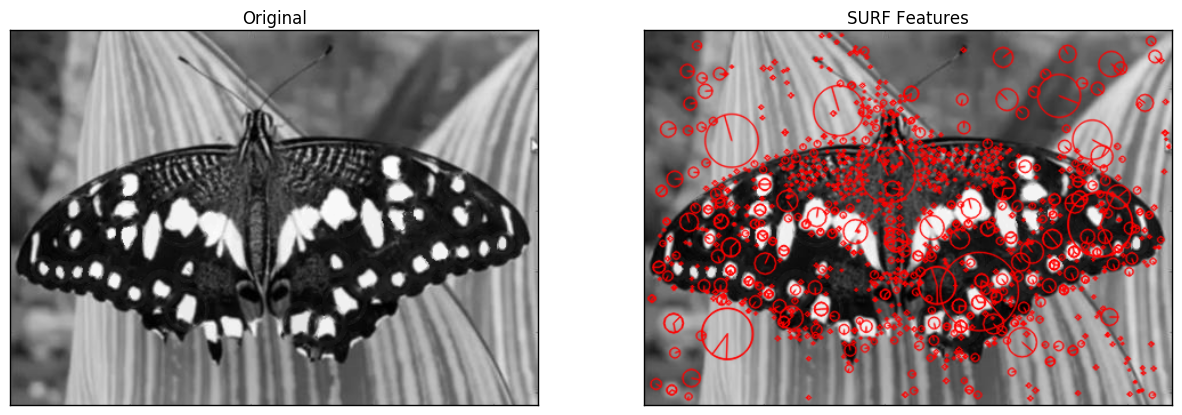

In [48]:
img_enhsurf=cv2.drawKeypoints(gray,kp,imsurf, (255,0,0),4)

plt.figure(figsize = (15,10))
plt.subplot(121),plt.imshow(gray, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_enhsurf, cmap='gray'),plt.title('SURF Features')
plt.xticks([]), plt.yticks([])

plt.show()